In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from copy import deepcopy
import time
import random
from scipy import stats
from scipy.stats import mode
import seaborn as sns
import warnings
from collections import defaultdict
warnings.filterwarnings("ignore")
from scipy.stats import chisquare

## Hits where antibiotic resistance evolves first
#### Exclude hits with two non-related antibiotics -> these go in co-linearity section

In [3]:
# Merge sequential and simultaneous hits into a single table

all_hits_sequential = pd.read_csv("output/04A.pair_annotation/results_allpairs_annotation_withcategories.csv", index_col=0)
all_simultaneous = pd.read_csv("output/04B.pair_annotation/results_allpairs_annotation_withcategories.csv", index_col=0)

sequential_merged = all_hits_sequential.merge(all_simultaneous[["position_i", "position_j", "pval_beta_i_on_j", 'pval_beta_i_on_j_BH_sig']], 
                                                on=["position_i", "position_j"], how="left", suffixes=["_sequential", "_simultaneous"])

simultaneous_merged = all_simultaneous.merge(all_hits_sequential[["position_i", "position_j", "pval_beta_i_on_j", 'pval_beta_i_on_j_BH_sig']], 
                                                on=["position_i", "position_j"], how="left", suffixes=[ "_simultaneous", "_sequential"])

all_hits = pd.concat([simultaneous_merged, sequential_merged])
all_hits = all_hits.drop_duplicates(subset=["position_i", "position_j"]).reset_index(drop=True)


In [66]:
display_positions =['position_i', 'gene_name_i', 'position_j', 'gene_name_j',
       'n_mutations_i', 'n_mutations_j', 'n_branches_with_i',
    'n_muts_i_on_branch_j', 'n_muts_same_branch','pval_beta_i_on_j',
       'pval_beta_i_on_j_BH_sig']

In [67]:
all_simultaneous.query("position_j==2726142 and position_i==2155168")[display_positions]

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_muts_i_on_branch_j,n_muts_same_branch,pval_beta_i_on_j,pval_beta_i_on_j_BH_sig
16077,2155168,katG,2726142,None,1811,39,12564,0,3,0.180799,False


In [5]:
known_antibiotic_first = all_hits.dropna(subset=["known_drug_j"]).query("pval_beta_i_on_j_BH_sig_sequential or pval_beta_i_on_j_BH_sig_simultaneous")

known_antibiotic_first['num_dependent'] = known_antibiotic_first.n_muts_i_on_branch_j + known_antibiotic_first.n_muts_same_branch
know_ab_first = known_antibiotic_first.loc[known_antibiotic_first.possible_drug_i.isnull(), :]
know_ab_first.sort_values('num_dependent', ascending=False).head(40)
print(len(know_ab_first))

961


In [6]:
def _process_known_hits(input_list):
    """
    splits the possible associated drugs (string separated by ,) into a list
    """
    output_list = []
    for item in input_list:
        #print(item)
        if type(item) != str:
            output_list.append(np.nan)
        else:
            splitted = item.split(",")
            exclusive= list(set(splitted))
            output_list.append(exclusive)
    return output_list

known_antibiotic_first = all_hits.dropna(subset=["known_drug_j"]).query("pval_beta_i_on_j_BH_sig_sequential or pval_beta_i_on_j_BH_sig_simultaneous")

known_antibiotic_first["known_drug_i"] = _process_known_hits(known_antibiotic_first.known_drug_i)
known_antibiotic_first["possible_drug_i"] = _process_known_hits(known_antibiotic_first.possible_drug_i)

known_antibiotic_first["known_drug_j"] = _process_known_hits(known_antibiotic_first.known_drug_j)
known_antibiotic_first["possible_drug_j"] = _process_known_hits(known_antibiotic_first.possible_drug_j)

print(len(known_antibiotic_first))

2043


In [7]:
between_antibiotic_indices = []
antibiotic_indices = []

known_antibiotic_first["within_same_drug"] = False

for idx, row in known_antibiotic_first.iterrows():
    
    set_of_known_first = set(row.known_drug_j)
    set_of_known_second = set()
    known_drug_second = False
    
    if type(row.known_drug_i) is list:
        set_of_known_second= set(row.known_drug_i)
        known_drug_second = True
        
    elif type(row.possible_drug_i) is list:
        set_of_known_second= set(row.possible_drug_i)
        known_drug_second = True
        
    if not known_drug_second:
        antibiotic_indices.append(idx)
    
    elif len(set_of_known_first.intersection(set_of_known_second)) > 0:
        antibiotic_indices.append(idx)
        known_antibiotic_first.loc[idx, "within_same_drug"] = True
        
    else:
        between_antibiotic_indices.append(idx)
        
between_antibiotic_hits = known_antibiotic_first.loc[between_antibiotic_indices]
antibiotic_hits = known_antibiotic_first.loc[antibiotic_indices]
    

In [8]:
!mkdir output/05.antibiotic
antibiotic_hits.to_csv("output/05.antibiotic/antibiotic_hits.csv")
between_antibiotic_hits.to_csv("output/05.antibiotic/between_antibiotic_hits.csv")
all_hits.to_csv("output/05.antibiotic/all_pairs.csv")

mkdir: cannot create directory ‘output/05.antibiotic’: File exists


## Compute per-drug output tables

In [9]:
## These will contain all hits except the between-antibiotic hits

## First get the list of all names of drugs in the dataset
drug_list = []
for idx, row in antibiotic_hits.iterrows():
    drugs1 = row.possible_drug_j
    drugs2 = row.possible_drug_i
    
    if type(drugs1) != list:
        drugs1= []
    if type(drugs2) != list:
        drugs2=[]
    
    for drug in drugs1 + drugs2:
        drug_list.append(drug)

drug_list = list(set(drug_list))

## Then create an empty df for each
df_dict = {drug:pd.DataFrame() for drug in drug_list}

## now concatenate each row to the appropriate drug dataframe
for idx, row in antibiotic_hits.iterrows():
    drugs1 = row.possible_drug_j
    drugs2 = row.possible_drug_i
    
    if type(drugs1) != list:
        drugs1= []
    if type(drugs2) != list:
        drugs2=[]
    
    for drug in drugs1:
        df_dict[drug] = df_dict[drug].append(row)
        
    for drug in drugs2:
        df_dict[drug] = df_dict[drug].append(row)
        
for drug, df in df_dict.items():
    print(drug, len(df))
    df.sort_values("n_muts_i_on_branch_j", ascending=False).to_csv(f"output/05.antibiotic/{drug}_antibiotic_hits.csv")
    df.query("pval_beta_i_on_j_BH_sig_sequential != 0").query("pval_beta_i_on_j_BH_sig_sequential").sort_values(
        "n_muts_i_on_branch_j", ascending=False
    ).to_csv(f"output/05.antibiotic/{drug}_antibiotic_hits_sequential.csv")

ETH 46
LZD 68
STM 215
EMB 271
CAP 67
PZA 129
LEV 15
MXF 15
KAN 101
INH 174
RIF 152
AMI 101


In [10]:
df

,Unnamed: 0,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_branches_with_j,n_muts_i_on_branch_j,...,in_antigen_epitope_j,in_antigen_protein_j,in_known_ABR_position_j,known_drug_j,in_possible_ABR_gene_j,possible_drug_j,annotation,pval_beta_i_on_j_sequential,pval_beta_i_on_j_BH_sig_sequential,within_same_drug
58212,55219,27490,None,1472359,None,6,233,8,870,1,...,False,False,True,[STM],True,"[LZD, STM, CAP, KAN, AMI]",known_AB_first,6.726209e-02,False,False
58228,55236,13638,None,1472359,None,35,233,14,870,2,...,False,False,True,[STM],True,"[LZD, STM, CAP, KAN, AMI]",known_AB_first,7.910976e-02,False,False
58243,55254,1254056,Rv1129c,1472359,None,50,233,42,870,0,...,False,False,True,[STM],True,"[LZD, STM, CAP, KAN, AMI]",known_AB_first,NaN,False,False
58270,55281,1338877,None,1472359,None,15,233,10,870,3,...,False,False,True,[STM],True,"[LZD, STM, CAP, KAN, AMI]",known_AB_first,6.937649e-04,False,False
58307,55320,13624,None,1472359,None,12,233,48,870,0,...,False,False,True,[STM],True,"[LZD, STM, CAP, KAN, AMI]",known_AB_first,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733445,816128,1388042,Rv1245c,1473246,None,6,560,12,1893,3,...,False,False,True,"[CAP, KAN, AMI]",True,"[LZD, STM, CAP, KAN, AMI]",known_AB_first,1.254120e-04,True,False
733536,816239,1662236,Rv1473,1473246,None,6,560,16,1893,3,...,False,False,True,"[CAP, KAN, AMI]",True,"[LZD, STM, CAP, KAN, AMI]",known_AB_first,1.226512e-04,True,False
790872,1445064,1472359,None,781687,rpsL,233,783,870,5303,38,...,False,False,True,[STM],True,[STM],between_known_AB,3.367794e-05,True,True
790946,1445155,3568795,None,781687,rpsL,15,783,64,5303,9,...,False,False,True,[STM],True,[STM],known_AB_first,7.254204e-09,True,True


In [11]:
## These will contain all hits except the between-antibiotic hits

## First get the list of all names of drugs in the dataset
drug_list = []
for idx, row in between_antibiotic_hits.iterrows():
    drugs1 = row.possible_drug_j
    drugs2 = row.possible_drug_i
    
    if type(drugs1) != list:
        drugs1= []
    if type(drugs2) != list:
        drugs2=[]
    
    for drug in drugs1 + drugs2:
        drug_list.append(drug)

drug_list = list(set(drug_list))

## Then create an empty df for each
df_dict = {drug:pd.DataFrame() for drug in drug_list}

## now concatenate each row to the appropriate drug dataframe
for idx, row in between_antibiotic_hits.iterrows():
    drugs1 = row.possible_drug_j
    drugs2 = row.possible_drug_i
    
    if type(drugs1) != list:
        drugs1= []
    if type(drugs2) != list:
        drugs2=[]
    
    for drug in drugs1:
        df_dict[drug] = df_dict[drug].append(row)
        
    for drug in drugs2:
        df_dict[drug] = df_dict[drug].append(row)
        
for drug, df in df_dict.items():
    print(drug, len(df))
    df.sort_values("n_muts_i_on_branch_j", ascending=False).to_csv(f"output/05.antibiotic/{drug}_between_antibiotic_hits.csv")

ETH 66
BDQ 2
LZD 153
STM 317
CAP 153
LEV 154
PZA 334
EMB 418
CFZ 2
MXF 154
KAN 227
INH 205
RIF 465
AMI 227


## Fraction of resistant strains with a dependent mutation

In [12]:
# Here let strains with a resistance-conferring mutation be defined as resistant
# Then count the number of resistant strains that have another mutation

snps = pd.read_csv("output/03.annotation/snps_with_all_annotation.csv", index_col=0)
snps = snps.query("not is_lineage")

# list of resistance mutations
resistance_mutations = snps.query("in_known_ABR_position")
resistance_mutations["known_drug"] = _process_known_hits(resistance_mutations.known_drug)

antibiotic_hits = antibiotic_hits.query("pval_beta_i_on_j_BH_sig_sequential")
print(len(antibiotic_hits))
# list of all other mutations
other_positions = list(set(antibiotic_hits.position_i))
other_mutations = snps.query("pos in @other_positions")



561


In [13]:
# # Read in the matrix of isolate x genotype
# # Input information from Roger
genotype_translator = {
0:"A", 1:"C", 2:"G", 3:"T", 9:"N"
}
isolate_annotation_file = "/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_isolate_annotation.pkl"
genotype_array_file = "/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_matrix.npy"
snp_annotation_file = "/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_SNP_annotation.pkl"
genotype_translator_r = {y:x for x,y in genotype_translator.items()}

isolates = pd.read_pickle(isolate_annotation_file)
genotypes = np.load(genotype_array_file)
snps_older = pd.read_pickle(snp_annotation_file)
# # Filter out the snps we don't need
snps_to_retain = snps_older.query("pos in @other_positions or pos in @resistance_mutations.pos")
indices_to_keep = snps_to_retain.index

g = genotypes[indices_to_keep, :]
del genotypes
np.save("output/05.antibiotic/antibiotic_genotypes_matrix.npy", g)
g = np.load("output/05.antibiotic/antibiotic_genotypes_matrix.npy")

In [14]:
snps_to_retain = snps_to_retain.reset_index()

In [15]:
# For each drug, get the set of mutations we are looking for
drug_to_sensitive_sites = {drug:[] for drug in drug_list}
for idx, row in resistance_mutations.iterrows():
    for drug in row.known_drug:
        drug_to_sensitive_sites[drug].append((row.pos, row.ref))

# Find strains that have any of those mutations
drug_to_indices_R_strains = {}

_num_sequential_dependencies = []
for drug, list_of_tuples in drug_to_sensitive_sites.items():
    
    has_sensitive_alleles = np.ones(shape=(len(list_of_tuples), g.shape[1]))
    #print(drug)
    
    for idx, (pos, nt) in enumerate(list_of_tuples):
    
        matrix_index = snps_to_retain.query("pos==@pos").index
        has_sensitive_alleles[idx,:] = g[matrix_index, :] == genotype_translator_r[nt]
        
    #print(np.sum(np.sum(has_sensitive_alleles, axis=0) < has_sensitive_alleles.shape[0]))
    indices_R_strains = np.where(np.sum(has_sensitive_alleles, axis=0) < has_sensitive_alleles.shape[0])[0]
    drug_to_indices_R_strains[drug] = indices_R_strains
    
    try:
        drug_specific_dependencies = pd.read_csv(f"output/05.antibiotic/{drug}_antibiotic_hits.csv", index_col=0)
    except:
        print("no file for", drug)
        continue
    drug_specific_dependencies = drug_specific_dependencies.query(
        "pval_beta_i_on_j_BH_sig_sequential")
    
    # Get the dependent positions - exclude any known resistance mutation from dependent sites
    dependent_positions = set(drug_specific_dependencies.position_i) - set(resistance_mutations.pos)
    dependencies = snps_to_retain.query("pos in @dependent_positions")
    #print(drug, "has", len(dependencies), "dependencies excluding known R positions")
    assert(len(dependent_positions) == len(dependencies))
    
    # Create a matrix of which strains have a dependent mutation
    _dependency_df = []
    has_dependent_alleles = np.ones(shape=(len(dependencies), len(indices_R_strains)))
    for mat_idx, (idx, row) in enumerate(dependencies.iterrows()):
        has_dependency = g[:, indices_R_strains][idx, :] != genotype_translator_r[row.ref]
        total_has_dependency = g[idx, :] != genotype_translator_r[row.ref]
        _dependency_df.append([idx, row.pos, row.ref, np.sum(has_dependency), np.sum(total_has_dependency)])
        has_dependent_alleles[mat_idx, :] = has_dependency
    
    dependency_df = pd.DataFrame(_dependency_df, columns=["matrix_idx", "pos", "ref", "num_R_strains_with_dependency", "total_strains_with_mutation"])
    dependency_df.to_csv(f"output/05.antibiotic/strains_with_dependencies_per_AB/{drug}.csv")
    
    _num_sequential_dependencies.append([drug, len(indices_R_strains), np.sum(np.sum(has_dependent_alleles, axis=0) > 0)])

df = pd.DataFrame(_num_sequential_dependencies, columns=["drug", "num_R_strains", "num_R_strains_with_dependency"])
df["fraction"] = df.num_R_strains_with_dependency / df.num_R_strains
df.to_csv("output/05.antibiotic/num_strains_with_dependency.csv")    
df

no file for BDQ
no file for CFZ


,drug,num_R_strains,num_R_strains_with_dependency,fraction
0,ETH,5744,1513,0.263405
1,LZD,109,53,0.486239
2,STM,10967,8707,0.793927
3,CAP,3194,1153,0.360989
4,LEV,3153,297,0.094196
5,PZA,9563,3979,0.416083
6,EMB,7235,3464,0.478784
7,MXF,3153,297,0.094196
8,KAN,4410,1916,0.434467
9,INH,11143,6236,0.559634


In [16]:
# Here let strains with a resistance-conferring mutation be defined as resistant
# Then count the number of resistant strains that have another mutation
#include simultaenous and sequential

snps = pd.read_csv("output/03.annotation/snps_with_all_annotation.csv", index_col=0)
snps = snps.query("not is_lineage")

# list of resistance mutations
resistance_mutations = snps.query("in_known_ABR_position")
resistance_mutations["known_drug"] = _process_known_hits(resistance_mutations.known_drug)
antibiotic_hits = pd.read_csv("output/05.antibiotic/antibiotic_hits.csv")
print(len(antibiotic_hits))
# list of all other mutations
antibiotic_hits["dist"] = np.abs(antibiotic_hits.position_j - antibiotic_hits.position_i)
antibiotic_hits = antibiotic_hits.query("pval_beta_i_on_j_BH_sig_sequential or (pval_beta_i_on_j_BH_sig_simultaneous and dist >100)")
print(len(antibiotic_hits))


1002
992


In [17]:

other_positions = list(set(antibiotic_hits.position_i))
other_mutations = snps.query("pos in @other_positions")

# # Read in the matrix of isolate x genotype
# # Input information from Roger
genotype_translator = {
0:"A", 1:"C", 2:"G", 3:"T", 9:"N"
}
isolate_annotation_file = "/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_isolate_annotation.pkl"
genotype_array_file = "/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_matrix.npy"
snp_annotation_file = "/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_SNP_annotation.pkl"
genotype_translator_r = {y:x for x,y in genotype_translator.items()}

isolates = pd.read_pickle(isolate_annotation_file)
genotypes = np.load(genotype_array_file)
snps_older = pd.read_pickle(snp_annotation_file)
# # Filter out the snps we don't need
snps_to_retain = snps_older.query("pos in @other_positions or pos in @resistance_mutations.pos")
indices_to_keep = snps_to_retain.index

g = genotypes[indices_to_keep, :]
del genotypes
np.save("output/05.antibiotic/antibiotic_genotypes_matrix.npy", g)
g = np.load("output/05.antibiotic/antibiotic_genotypes_matrix.npy")

snps_to_retain = snps_to_retain.reset_index()

In [18]:
# For each drug, get the set of mutations we are looking for
drug_to_sensitive_sites = {drug:[] for drug in drug_list}
for idx, row in resistance_mutations.iterrows():
    for drug in row.known_drug:
        drug_to_sensitive_sites[drug].append((row.pos, row.ref))

# Find strains that have any of those mutations
drug_to_indices_R_strains = {}

_num_sequential_dependencies = []
for drug, list_of_tuples in drug_to_sensitive_sites.items():
    
    has_sensitive_alleles = np.ones(shape=(len(list_of_tuples), g.shape[1]))
    #print(drug)
    
    # Determine if each isolate has any sensitive allele
    for idx, (pos, nt) in enumerate(list_of_tuples):
    
        matrix_index = snps_to_retain.query("pos==@pos").index
        has_sensitive_alleles[idx,:] = g[matrix_index, :] == genotype_translator_r[nt]
        
    #print(np.sum(np.sum(has_sensitive_alleles, axis=0) < has_sensitive_alleles.shape[0]))
    indices_R_strains = np.where(np.sum(has_sensitive_alleles, axis=0) < has_sensitive_alleles.shape[0])[0]
    drug_to_indices_R_strains[drug] = indices_R_strains
    
    try:
        drug_specific_dependencies = pd.read_csv(f"output/05.antibiotic/{drug}_antibiotic_hits.csv", index_col=0)
    except:
        print("no file for", drug)
        continue
    #drug_specific_dependencies = drug_specific_dependencies.query("pval_beta_i_on_j_BH_sig_sequential == 'True'")
    
    # Get the dependent positions - exclude any known resistance mutation from dependent sites
    dependent_positions = set(drug_specific_dependencies.position_i) - set(resistance_mutations.pos)
    dependencies = snps_to_retain.query("pos in @dependent_positions")
    #print(drug, "has", len(dependencies), "dependencies excluding known R positions")
    assert(len(dependent_positions) == len(dependencies))
    
    # Create a matrix of which strains have a dependent mutation
    _dependency_df = []
    has_dependent_alleles = np.ones(shape=(len(dependencies), len(indices_R_strains)))
    for mat_idx, (idx, row) in enumerate(dependencies.iterrows()):
        has_dependency = g[:, indices_R_strains][idx, :] != genotype_translator_r[row.ref]
        total_has_dependency = g[idx, :] != genotype_translator_r[row.ref]
        _dependency_df.append([idx, row.pos, row.ref, np.sum(has_dependency), np.sum(total_has_dependency)])
        has_dependent_alleles[mat_idx, :] = has_dependency
    
    dependency_df = pd.DataFrame(_dependency_df, columns=["matrix_idx", "pos", "ref", "num_R_strains_with_dependency", "total_strains_with_mutation"])
    dependency_df.to_csv(f"output/05.antibiotic/strains_with_dependencies_per_AB/{drug}.csv")
    
    _num_sequential_dependencies.append([drug, len(indices_R_strains), np.sum(np.sum(has_dependent_alleles, axis=0) > 0)])
    
df = pd.DataFrame(_num_sequential_dependencies, columns=["drug", "num_R_strains", "num_R_strains_with_dependency"])
df["fraction"] = df.num_R_strains_with_dependency / df.num_R_strains
df.to_csv("output/05.antibiotic/num_strains_with_dependency_simultaneous.csv")    


no file for BDQ
no file for CFZ


### Plot fraction of resistant strains with a dependent mutation

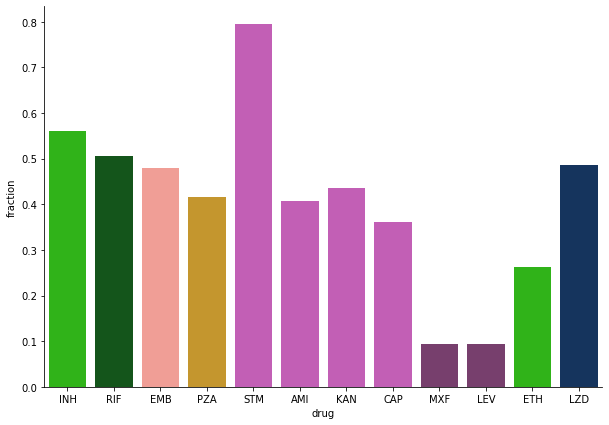

In [19]:
list_of_colors = [
    (30, 204, 0),
    (9, 96, 19),
    (255, 146, 135),
    (221, 160, 21),
    (210,78,193),
    (210,78,193),
    (210,78,193),
    
    (210,78,193),
    
    (128,54,115),
    (128,54,115),
    (30,204,0),
    (9, 50, 105),
    
    (128,54,115),
    (128,54,115),
    (128,54,115),
    (128,54,115),
    (139,192,221),
    (9, 50, 105),

    (189,189,189)
]
list_of_colors = [(x/255,y/255, z/255) for x,y,z in list_of_colors]

# Make plot

df_both = pd.read_csv("output/05.antibiotic/num_strains_with_dependency_simultaneous.csv", index_col=0) 
df_single = pd.read_csv("output/05.antibiotic/num_strains_with_dependency.csv", index_col=0)  

df_both["label"]= "both"
df_single["label"] = "sequential_only"

sorted_drug_list = [ 'INH', "RIF", "EMB", "PZA", 
                     'STM', 'AMI','KAN', 'CAP',
                     'MXF', 'LEV', 'ETH',
                    'DLM','CFZ','LZD','BDQ'
]

#df = pd.concat([df_both, df_single])
df = df_single
# Generate a rank column that will be used to sort
# the dataframe numerically
sorterIndex = dict(zip(sorted_drug_list, range(len(sorted_drug_list))))
df['ab_rank'] = df['drug'].map(sorterIndex)
df = df.sort_values("ab_rank")
sns.set_palette(sns.color_palette(list_of_colors))
figure=plt.figure(figsize=(10,7))
sns.barplot(data=df,x="drug", y="fraction", palette= sns.color_palette(list_of_colors))
sns.despine()
plt.savefig("figures/percent_strains_with_dependency.pdf")

## Prepare Cytoscape plot of between-antibiotic dependencies

In [20]:
!mkdir output/05.antibiotic/cytoscape

mkdir: cannot create directory ‘output/05.antibiotic/cytoscape’: File exists


In [21]:
N=1
_p = []

for drug in drug_list: 
    try:
        ab_hits = pd.read_csv(f"output/05.antibiotic/{drug}_antibiotic_hits.csv", index_col=0).drop_duplicates()
        between_hits = pd.read_csv(f"output/05.antibiotic/{drug}_between_antibiotic_hits.csv", index_col=0).drop_duplicates()
        
        ## ThyX is antibiotic associated
        #ab_hits = ab_hits.query("gene_name_i != 'r_thyX' and gene_name_i != 'r_thyA'")
    except:
        continue

    allhits = ab_hits
    allhits['overlap'] = allhits.n_muts_i_on_branch_j + allhits.n_muts_same_branch
    print(drug, len(allhits))
    
    # filtering
    allhits = allhits.query("overlap > 9")
    
    allhits = allhits.sort_values("overlap", ascending=False)
    p = allhits.head(N)[["position_i", "gene_name_i", "position_j", "gene_name_j", "overlap"]]
    p["drug"] = drug
    print(p)
    _p.append(p)
    
    between_ab = between_hits
    between_ab['overlap'] = between_ab.n_muts_i_on_branch_j + between_ab.n_muts_same_branch
    between_ab = between_ab.sort_values("overlap", ascending=False)
    
    between_ab = between_ab.query("overlap > 9")
    
    p = between_ab.head(N)[["position_i", "gene_name_i", "position_j", "gene_name_j", "overlap"]]
    p["drug"] = drug
    print(p)
    _p.append(p)
    
df = pd.concat(_p)
df = df.reset_index(drop=True)
df.loc[df.query("position_i==3073679").index, "gene_name_i"] = "r_thyA"

df['name_i']=[f'{x}_{y}' for x,y in zip(df.gene_name_i, df.position_i)]
df['name_j']=[f'{x}_{y}' for x,y in zip(df.gene_name_j, df.position_j)]

df.to_csv(f"output/05.antibiotic/cytoscape//top_{N}_hits_per_drug_2022.csv")
df

ETH 46
       position_i gene_name_i  position_j gene_name_j  overlap drug
51629     1673425        None     1674481        inhA       27  ETH
       position_i gene_name_i  position_j gene_name_j  overlap drug
51582      761155        rpoB     1674481        inhA       26  ETH
LZD 68
        position_i gene_name_i  position_j gene_name_j  overlap drug
664738      781687        rpsL     1472362        None       41  LZD
       position_i gene_name_i  position_j gene_name_j  overlap drug
49143     1473246        None     2155168        katG      254  LZD
STM 211
        position_i gene_name_i  position_j gene_name_j  overlap drug
664738      781687        rpsL     1472362        None       41  STM
       position_i gene_name_i  position_j gene_name_j  overlap drug
49053      781687        rpsL     2155168        katG      434  STM
CAP 67
        position_i gene_name_i  position_j gene_name_j  overlap drug
664738      781687        rpsL     1472362        None       41  CAP
       positi

,position_i,gene_name_i,position_j,gene_name_j,overlap,drug,name_i,name_j
0,1673425,None,1674481,inhA,27,ETH,None_1673425,inhA_1674481
1,761155,rpoB,1674481,inhA,26,ETH,rpoB_761155,inhA_1674481
2,781687,rpsL,1472362,None,41,LZD,rpsL_781687,None_1472362
3,1473246,None,2155168,katG,254,LZD,None_1473246,katG_2155168
4,781687,rpsL,1472362,None,41,STM,rpsL_781687,None_1472362
5,781687,rpsL,2155168,katG,434,STM,rpsL_781687,katG_2155168
6,781687,rpsL,1472362,None,41,CAP,rpsL_781687,None_1472362
7,1473246,None,2155168,katG,254,CAP,None_1473246,katG_2155168
8,7582,gyrA,2155168,katG,339,LEV,gyrA_7582,katG_2155168
9,2289252,None,2155168,katG,87,PZA,None_2289252,katG_2155168


In [22]:
# mutations in same gene or region get condensed

g= df.groupby(["gene_name_i", "gene_name_j"]).agg({
    "overlap":"sum",
    "drug":"max"
})
g["name_i"] = g.index.get_level_values(0)
g["name_j"] = g.index.get_level_values(1)
g.name_i = [x.replace("r_","p_") for x in g.name_i]
g.name_j = [x.replace("r_","p_") for x in g.name_j]
#g["drug"] = [gene_to_ab[x] if x in gene_to_ab else None for x in g.index.get_level_values(0)]

g.to_csv(f"output/05.antibiotic/cytoscape/top_{N}_hits_per_drug_grouped.csv")
g

overlap drug name_i name_j
gene_name_i gene_name_j                            
None        inhA              27  ETH   None   inhA
            katG            1277  PZA   None   katG
embB        embB              41  EMB   embB   embB
            katG             454  EMB   embB   katG
gyrA        katG             678  MXF   gyrA   katG
rpoB        inhA              26  ETH   rpoB   inhA
            katG            1630  RIF   rpoB   katG
rpoC        rpoB             183  RIF   rpoC   rpoB
rpsL        None             205  STM   rpsL   None
            katG             434  STM   rpsL   katG

In [23]:
gene_names = set(list(g.name_i.values) + list(g.name_j.values))

In [24]:
gene_name_to_drug = {
 'embB':"EMB",
 'gyrA':"FQ",
 'inhA':"INH_ETA",
 'katG':"INH",
 'p_fabG1':"INH_ETA",
 'p_pncA':"PZA",
 'rpoB':"RIF",
 'rpoC':"RIF",
 'rpsL':"STM",
 'rrs':"AMG"}
    

In [25]:
individual_attributes = pd.concat([
    g[["name_i", "drug"]],
]).reset_index()

individual_attributes['known'] = False

individual_attributes["drug"] = [gene_name_to_drug[x] if x in gene_name_to_drug else "UK" for x in individual_attributes.name_i]

individual_attributes = individual_attributes.rename({"name_i": "name"}, axis=1)

drug_to_color = {
    'AMG':'#d24ec1',
    'CYS': '#8bc0dd',
    'EMB':'#FF9287',
    'ETH':'#a0e85b',
    'INH':'#a0e85b', 
    'INH_ETA':'#a0e85b',
    'FQ':'#57377e',
    'CIP':'#57377e',
    'PAS':'#155392',
    'PZA': '#6a3d9a',
    'RIF':'#34a54f',
    'RFB':'#34a54f',
    'STM':'#fcc2fb',
    "UK":"#AAAAAA"
}


individual_attributes['color'] = [drug_to_color[x] for x in 
    individual_attributes.drug]

individual_attributes.to_csv(f'output/05.antibiotic/cytoscape/top_{N}_hits_per_drug_grouped_indiv.csv')

## Prepare for CIRCOS plot of after-antibiotic mutations

## Presence of Featured mutations in the paper

In [69]:
antibiotic_hits = pd.read_csv("output/05.antibiotic/antibiotic_hits.csv")
display_positions =['position_i', 'gene_name_i', 'position_j', 'gene_name_j',
       'n_mutations_i', 'n_mutations_j', 'n_branches_with_i',
    'n_muts_i_on_branch_j', 'n_muts_same_branch',
       'pval_beta_i_on_j_BH_sig_sequential', 'pval_beta_i_on_j_BH_sig_simultaneous']
antibiotic_hits.query('gene_name_i=="nusG" and gene_name_j=="rpoB"')[display_positions]

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_muts_i_on_branch_j,n_muts_same_branch,pval_beta_i_on_j_BH_sig_sequential,pval_beta_i_on_j_BH_sig_simultaneous
100,734624,nusG,761155,rpoB,14,1487,32,4,6,False,True
109,734470,nusG,761155,rpoB,6,1487,10,1,3,False,True


In [70]:
all_hits.query('position_i==2726142 and gene_name_j=="katG"')[display_positions]

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_muts_i_on_branch_j,n_muts_same_branch,pval_beta_i_on_j_BH_sig_sequential,pval_beta_i_on_j_BH_sig_simultaneous
629831,2726142,None,2155783,katG,39,9,20,1,0,False,NaN
694271,2726142,None,2155168,katG,39,1811,20,14,3,False,NaN


In [75]:
all_hits.query('position_j==2726142 and gene_name_i=="katG"')[display_positions]

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_muts_i_on_branch_j,n_muts_same_branch,pval_beta_i_on_j_BH_sig_sequential,pval_beta_i_on_j_BH_sig_simultaneous
7004,2154083,katG,2726142,None,7,39,0,0,1,NaN,True
7012,2155541,katG,2726142,None,35,39,32,0,1,NaN,False
7014,2156110,katG,2726142,None,6,39,0,0,1,NaN,True
7015,2155295,katG,2726142,None,6,39,2,0,1,NaN,True
52763,2155168,katG,2726142,None,1811,39,12564,0,3,False,False
52774,2155167,katG,2726142,None,56,39,136,0,1,NaN,False
518330,2155783,katG,2726142,None,9,39,16,0,0,False,NaN


In [71]:
antibiotic_hits.query('gene_name_i=="hadA" and gene_name_j=="katG"')[display_positions]

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_muts_i_on_branch_j,n_muts_same_branch,pval_beta_i_on_j_BH_sig_sequential,pval_beta_i_on_j_BH_sig_simultaneous
20,732110,hadA,2155168,katG,57,1811,84,12,28,False,True
23,732111,hadA,2155168,katG,16,1811,42,3,10,False,True


In [72]:
# whiB7 upstream region
all_hits.query('gene_name_i=="r_whiB7" and gene_name_j=="whiB6"')[display_positions]
# whiB7
all_hits.query('position_i > 3568679 and position_i <3569109 and gene_name_j=="whiB6"')[display_positions]

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_muts_i_on_branch_j,n_muts_same_branch,pval_beta_i_on_j_BH_sig_sequential,pval_beta_i_on_j_BH_sig_simultaneous
821891,3568795,None,4338473,whiB6,15,18,64,0,0,False,NaN
876097,3568795,None,4338292,whiB6,15,6,64,0,0,False,NaN
876240,3568795,None,4338371,whiB6,15,8,64,4,0,True,NaN


In [73]:

# eis upstream region
all_hits.query('position_i > 2714124 and position_i<2715472 and gene_name_j=="whiB6"')[display_positions]

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_muts_i_on_branch_j,n_muts_same_branch,pval_beta_i_on_j_BH_sig_sequential,pval_beta_i_on_j_BH_sig_simultaneous
57184,2715342,None,4338365,whiB6,139,48,350,0,1,NaN,False
70925,2715344,None,4338473,whiB6,75,18,526,1,1,False,False
675482,2715369,None,4338473,whiB6,40,18,506,1,0,False,NaN
676765,2715369,None,4338365,whiB6,40,48,506,0,0,False,NaN
779963,2715342,None,4338371,whiB6,139,8,350,19,0,True,NaN
779969,2715369,None,4338371,whiB6,40,8,506,5,0,False,NaN
779974,2715344,None,4338371,whiB6,75,8,526,2,0,False,NaN
780000,2715346,None,4338371,whiB6,82,8,190,2,0,False,NaN
809742,2715346,None,4338307,whiB6,82,5,190,1,0,False,NaN
876859,2714308,eis,4338471,whiB6,6,6,106,0,0,False,NaN


In [78]:

# eis upstream region and rrs - 41 mutations
all_hits.query('position_i > 2714124 and position_i<2715472 and position_j > 1471846 and position_j<1473382 and pval_beta_i_on_j_BH_sig_sequential ')[display_positions]

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_muts_i_on_branch_j,n_muts_same_branch,pval_beta_i_on_j_BH_sig_sequential,pval_beta_i_on_j_BH_sig_simultaneous
664917,2715346,None,1472362,None,82,115,190,8,3,True,NaN
699923,2715342,None,1472359,None,139,233,350,15,0,True,NaN
733076,2715342,None,1473246,None,139,560,350,14,1,True,NaN


In [79]:
# rrsto WhiB6 10 mutations
all_hits.query('position_i > 1471846 and position_i<1473382  and gene_name_j=="whiB6"and pval_beta_i_on_j_BH_sig_simultaneous ')[display_positions].head(10)

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_muts_i_on_branch_j,n_muts_same_branch,pval_beta_i_on_j_BH_sig_sequential,pval_beta_i_on_j_BH_sig_simultaneous
57179,1472359,None,4338365,whiB6,233,48,870,2,4,False,True
57196,1473247,None,4338365,whiB6,16,48,6,0,2,NaN,True
70922,1472359,None,4338473,whiB6,233,18,870,0,2,NaN,True
79162,1473246,None,4338471,whiB6,560,6,1893,0,2,NaN,True


In [32]:
antibiotic_hits.query("pval_beta_i_on_j_BH_sig_sequential").sort_values("n_muts_i_on_branch_j", ascending=False)[display_positions].head(50)

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_muts_i_on_branch_j,n_muts_same_branch,pval_beta_i_on_j_BH_sig_sequential,pval_beta_i_on_j_BH_sig_simultaneous
521,764817,rpoC,761155,rpoB,277,1487,921,78,105,True,NaN
641,2986827,Rv2670c,2155168,katG,95,1811,671,41,29,True,NaN
455,781687,rpsL,1472362,None,783,115,5303,41,0,True,NaN
892,1472359,None,781687,rpsL,233,783,870,38,1,True,NaN
596,3067961,None,2155168,katG,78,1811,286,29,24,True,NaN
581,3073679,None,2155168,katG,53,1811,192,25,5,True,NaN
513,3073679,None,761155,rpoB,53,1487,192,21,7,True,NaN
544,764840,rpoC,761155,rpoB,63,1487,192,20,17,True,NaN
580,1853001,rpmI,2155168,katG,26,1811,280,18,0,True,NaN
512,1853001,rpmI,761155,rpoB,26,1487,280,17,0,True,NaN


## Get the nucleotide changes for individual SNPs

In [31]:
snps = pd.read_pickle("/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_SNP_functional_annotation.pkl")
snps.query("gene_name=='katG'")

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,SNP_type,AA_change
2153889_C,2153889,T,C,Antibiotic Resistance,katG,Rv1908c,2223,N,*741W
2153891_G,2153891,A,G,Antibiotic Resistance,katG,Rv1908c,2221,N,*741R
2153897_T,2153897,C,T,Antibiotic Resistance,katG,Rv1908c,2215,N,V739M
2153905_T,2153905,C,T,Antibiotic Resistance,katG,Rv1908c,2207,N,R736K
2153908_G,2153908,T,G,Antibiotic Resistance,katG,Rv1908c,2204,N,D735A
...,...,...,...,...,...,...,...,...,...
2156104_C,2156104,T,C,Antibiotic Resistance,katG,Rv1908c,8,N,E3G
2156106_A,2156106,G,A,Antibiotic Resistance,katG,Rv1908c,6,S,P2P
2156109_A,2156109,C,A,Antibiotic Resistance,katG,Rv1908c,3,S,V1V
2156109_T,2156109,C,T,Antibiotic Resistance,katG,Rv1908c,3,S,V1V
